<a href="https://colab.research.google.com/github/amine-lbabda/STAI/blob/main/Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the EuroSAT dataset
dataset, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)

# Get the class names
class_names = info.features['label'].names
print("Available classes in dataset:", class_names)

# Define the nature-related classes to keep
classes_to_keep = ['Forest', 'HerbaceousVegetation', 'Pasture', 'River', 'SeaLake']

# Get the indices of classes to keep and convert to int64
indices_to_keep = tf.constant([class_names.index(class_name) for class_name in classes_to_keep], dtype=tf.int64)

def filter_classes(image, label):
    # Convert label to int64 to match indices_to_keep
    label = tf.cast(label, tf.int64)
    return tf.reduce_any(tf.equal(label, indices_to_keep))

@tf.function
def preprocess(image, label):
    # Convert image to float32 and normalize
    image = tf.cast(image, tf.float32) / 255.0

    # Convert label to int64
    label = tf.cast(label, tf.int64)

    # Create a mapping table
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            indices_to_keep,
            tf.range(tf.cast(tf.size(indices_to_keep), tf.int64))
        ),
        default_value=-1
    )

    # Map the old labels to new ones
    new_label = table.lookup(label)

    return image, new_label

# Initialize the lookup table (needs to be done before creating the dataset pipeline)
tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        indices_to_keep,
        tf.range(tf.cast(tf.size(indices_to_keep), tf.int64))
    ),
    default_value=-1
)

# Split and filter the dataset
train_dataset, test_dataset = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True
)

# Apply filtering and preprocessing
train_dataset = train_dataset.filter(filter_classes)
test_dataset = test_dataset.filter(filter_classes)

# Apply preprocessing and batching
train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# Print information about the filtered dataset
print("\nSelected nature-related classes:", classes_to_keep)
print("Number of selected classes:", len(classes_to_keep))

# Print the new label mapping
print("\nNew label mapping:")
for i, class_name in enumerate(classes_to_keep):
    print(f"Class '{class_name}' -> New label {i}")

# Optional: Verify the dataset
for images, labels in train_dataset.take(1):
    print("\nShape of first batch of images:", images.shape)
    print("Shape of first batch of labels:", labels.shape)
    print("Unique labels in first batch:", tf.unique(labels)[0])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.3DJBAA_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Available classes in dataset: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

Selected nature-related classes: ['Forest', 'HerbaceousVegetation', 'Pasture', 'River', 'SeaLake']
Number of selected classes: 5

New label mapping:
Class 'Forest' -> New label 0
Class 'HerbaceousVegetation' -> New label 1
Class 'Pasture' -> New label 2
Class 'River' -> New label 3
Class 'SeaLake' -> New label 4

Shape of first batch of images: (32, 64, 64, 3)
Shape of first batch of labels: (32,)
Unique labels in first batch: tf.Tensor([0 1 3 2 4], shape=(5,), dtype=int64)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # EuroSAT has 10 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.fit(train_dataset, epochs=10, validation_data=test_dataset)


Epoch 1/10
    337/Unknown 89s 257ms/step - accuracy: 0.5128 - loss: 1.1731

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


338/338 ━━━━━━━━━━━━━━━━━━━━ 100s 287ms/step - accuracy: 0.5135 - loss: 1.1718 - val_accuracy: 0.7609 - val_loss: 0.6725
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 86s 255ms/step - accuracy: 0.7740 - loss: 0.5952 - val_accuracy: 0.8446 - val_loss: 0.4384
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 86s 254ms/step - accuracy: 0.8269 - loss: 0.4594 - val_accuracy: 0.8520 - val_loss: 0.4188
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 143s 257ms/step - accuracy: 0.8532 - loss: 0.3836 - val_accuracy: 0.8893 - val_loss: 0.3236
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 94s 278ms/step - accuracy: 0.8782 - loss: 0.3268 - val_accuracy: 0.9125 - val_loss: 0.2782
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 138s 267ms/step - accuracy: 0.8895 - loss: 0.3002 - val_accuracy: 0.9173 - val_loss: 0.2537
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 138s 254ms/step - accuracy: 0.9036 - loss: 0.2615 - val_accuracy: 0.9111 - val_loss: 0.2634
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 149s 274ms/step - accuracy: 0.9175 - loss: 0.2269 

In [ ]:
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


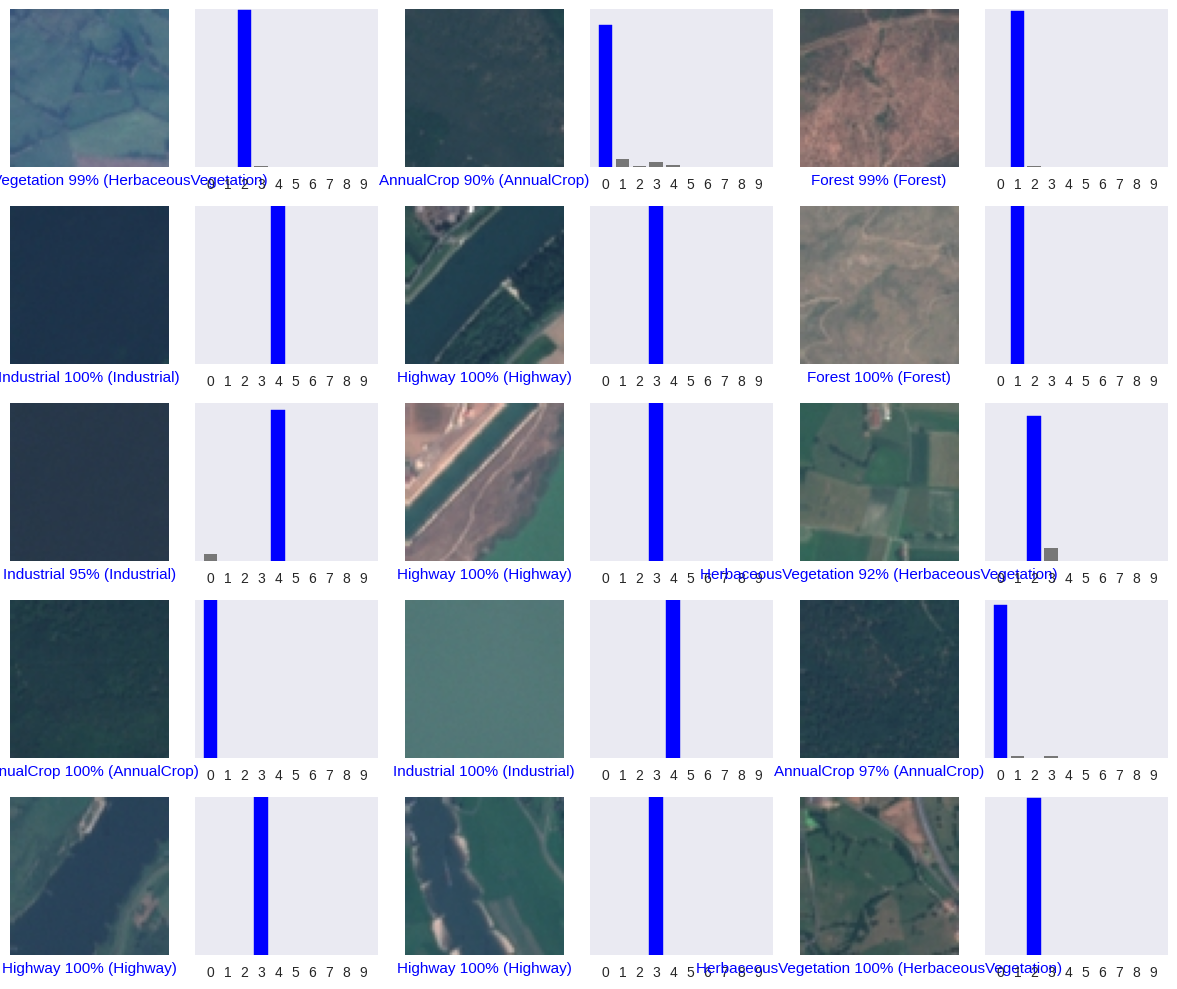

In [ ]:
class_names = info.features['label'].names

# Get a batch of images and labels from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)

    # Plot the images and predictions
    num_rows = 5
    num_cols = 3
    num_images = num_rows * num_cols
    plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        plt.imshow(images[i].numpy(), cmap=plt.cm.binary)

        predicted_label = tf.argmax(predictions[i])
        true_label = labels[i]

        if predicted_label == true_label:
            color = 'blue'
        else:
            color = 'red'

        plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                             100 * tf.reduce_max(predictions[i]),
                                             class_names[true_label]),
                                             color=color)

        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions[i], color="#777777")
        plt.ylim([0, 1])
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')

    plt.tight_layout()
    plt.show()


In [ ]:
model.save('Best_model.keras')

In [15]:
import tensorflow as tf
from PIL import Image
import numpy as np

# Load the image
image_path = '/content/R.jpg'
image = Image.open(image_path)

# Preprocess the image
image = image.resize((64, 64))  # Resize to the size your model expects
image = np.array(image) / 255.0   # Normalize the image
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Load your model
model = tf.keras.models.load_model('/content/Best_model.keras')

# Make predictions
predictions = model.predict(image)

# Process the predictions
predicted_class = np.argmax(predictions, axis=1)

predicted_int_class = int(predicted_class)
print(f'Predicted class: {class_names[predicted_int_class]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
Predicted class: Forest


<ipython-input-15-6360190e3cd3>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_int_class = int(predicted_class)
